# Overview
The following notebook is my attempt to investigate with different CNN architectures and how they hold up with fruit classification. The dataset used was gotten from https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Input, Flatten, Rescaling
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
import itertools
import os

## Set up kaggle directory and get data

In [ ]:
! kaggle datasets download kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
 99% 1.97G/1.98G [00:23<00:00, 57.5MB/s]
100% 1.98G/1.98G [00:23<00:00, 90.6MB/s]


In [ ]:
import zipfile
#Unzip file
zip_ref = zipfile.ZipFile("/content/fruit-and-vegetable-image-recognition.zip", "r")
zip_ref.extractall(path="")
zip_ref.close()

In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"

tf.random.set_seed(42)

# Constants
IMG_SIZE = (256,256)
BATCH_SIZE = 32
INPUT_SHAPE = IMG_SIZE + (3,)

all_class_names = os.listdir(train_dir)
print(f"All imported classes are: {all_class_names}")

All imported classes are: ['pineapple', 'cabbage', 'raddish', 'cauliflower', 'corn', 'tomato', 'garlic', 'sweetpotato', 'watermelon', 'pear', 'peas', 'carrot', 'spinach', 'turnip', 'lettuce', 'eggplant', 'sweetcorn', 'capsicum', 'onion', 'grapes', 'lemon', 'kiwi', 'apple', 'ginger', 'orange', 'bell pepper', 'beetroot', 'mango', 'chilli pepper', 'paprika', 'soy beans', 'cucumber', 'pomegranate', 'jalepeno', 'potato', 'banana']


# Useful helper functions:


In [ ]:
def view_random_images(ds,label_mode):
  #displays random image from dataset with corresponding label
  classes = ds.class_names
  for images,labels in ds.take(1):
    plt.figure(figsize=(12,12))
    for i in range(9):
      if label_mode=="binary":
        class_name = classes[int(labels[i][0].numpy())]
      else:
        class_name =  classes[tf.argmax(labels[i],axis=None)]
      plt.subplot(3,3,i+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.axis("off")
      plt.title(class_name)

  plt.show()

In [ ]:
import shutil

def copy_and_move(classes,data_dir,dest_dir):
  #moves folders specified with argument classes to dest_dir from data_dir
  #it is to be used for preprocessing before using image_dataset_from_direcotry
  for c in classes:
    print(c)
    From = data_dir + "/train/" + c
    dest = dest_dir + "/train/" + c
    move(From,dest)
    From = data_dir + "/test/" + c
    dest = dest_dir + "/test/" + c
    move(From,dest)
  return dest_dir+"/train",dest_dir +"/test"

def move(src,dest):
  try:
    path = shutil.copytree(src,dest)
  except:
    print("File already exists at: ",dest )


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

def get_train_test_ds(data_dir,dest_dir,classes,label_mode):
  #creates datasets of type tf.dataset for our trainign and testing data.
  tf.random.set_seed(42)

  train_dir,test_dir = copy_and_move(classes,data_dir,dest_dir)

  train_ds = image_dataset_from_directory(train_dir,
                                          image_size=IMG_SIZE,
                                          label_mode=label_mode,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
  test_ds = image_dataset_from_directory(test_dir,
                                         image_size=IMG_SIZE,
                                         label_mode=label_mode,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
  return train_ds, test_ds

In [ ]:
def plot_loss_acc_curves(history):
  # plots validaiton and training accuracy and loss
  plt.figure(figsize=(8,8))
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  plt.plot(loss,label="Loss")
  plt.plot(val_loss,label="Validation Loss")
  plt.figure(figsize=(8,8))
  plt.plot(accuracy,label="Accuracy")
  plt.plot(val_accuracy,label="Validaiton Accuracy")
  plt.legend()
  plt.show()

In [ ]:
def walk_down_dir(dir):
  #walks down the given directory and signifies number of directories and images.
  for (root,dirs,files) in os.walk(dir):
    print(f"{len(dirs)} directories and {len(files)} images in {root}.")


In [ ]:
from itertools import zip_longest

def predict_labels(model,test_ds,batch_number):
  #given model makes prediction on the first 9 elements of first batch of given dataset.
  class_labels = test_ds.class_names
  batch = list(test_ds.as_numpy_iterator())[batch_number]
  images_data = batch[0][:9]
  true_labels = batch[1][:9]
  model_preds = []


  for image in images_data:
    pred = model.predict(tf.expand_dims(image,axis=0))
    model_preds.append(tf.argmax(pred[0]).numpy())

  pred_labels = [class_labels[i] for i in model_preds]
  true_labels = [class_labels[tf.argmax(i).numpy()] for i in true_labels]

  plt.figure(figsize=(12,12))
  for i,image in enumerate(images_data):
    plt.subplot(3,3,i+1)
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
    plt.title(f"Actual Label: {true_labels[i]} \n  Predicted Label: {pred_labels[i]}." )

  plt.show()

# Model 1:
## Binary classification of Apple and Banana images with basic model

In [ ]:

binary_data_dir = "/content"
binary_classes = ["apple","banana"]
binary_dest_dir = "/content/binary"

train_binary_ds, test_binary_ds = get_train_test_ds(binary_data_dir,binary_dest_dir,binary_classes,"binary")

apple
banana
Found 143 files belonging to 2 classes.
Found 19 files belonging to 2 classes.


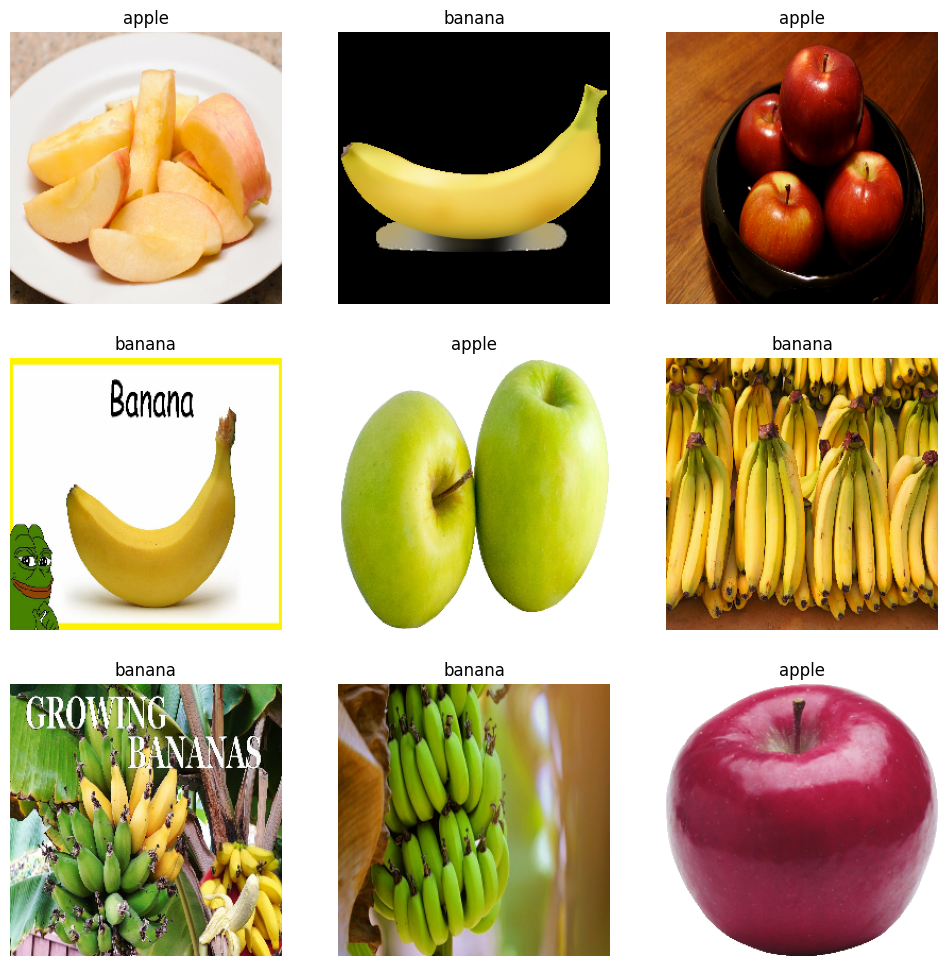

In [ ]:
view_random_images(train_binary_ds,label_mode="binary")

Let's now create our first model.

In [ ]:
def create_basic_model(activation,output_nodes):
  model= Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32,kernel_size=(3,3),activation="relu"),
    Conv2D(32,kernel_size=(3,3),activation="relu"),
    MaxPool2D((2,2)),
    Conv2D(64,kernel_size=(3,3),activation="relu"),
    Conv2D(32,kernel_size=(3,3),activation="relu"),
    Flatten(),
    Dense(output_nodes,activation=activation)
  ])
  return model


In [ ]:


binary_model_1 = create_basic_model("sigmoid",1)

binary_model_1.compile(loss="binary_crossentropy",
                       optimizer=Adam(),
                       metrics=["accuracy"])

history_1 = binary_model_1.fit(train_binary_ds,
                               epochs=5,
                               steps_per_epoch=len(train_binary_ds),
                               validation_data=test_binary_ds,
                               validation_steps=len(test_binary_ds))

Epoch 1/5
5/5 [==============================] - 53s 9s/step - loss: 955.4284 - accuracy: 0.4895 - val_loss: 32.6118 - val_accuracy: 0.8421
Epoch 2/5
5/5 [==============================] - 47s 8s/step - loss: 52.4424 - accuracy: 0.7203 - val_loss: 25.8440 - val_accuracy: 0.8421
Epoch 3/5
5/5 [==============================] - 48s 9s/step - loss: 36.1718 - accuracy: 0.7902 - val_loss: 14.5590 - val_accuracy: 0.8421
Epoch 4/5
5/5 [==============================] - 49s 9s/step - loss: 15.2257 - accuracy: 0.8112 - val_loss: 0.6787 - val_accuracy: 0.9474
Epoch 5/5
5/5 [==============================] - 46s 8s/step - loss: 6.6031 - accuracy: 0.7832 - val_loss: 0.9547 - val_accuracy: 0.8947


In [ ]:
binary_model_1.evaluate(test_binary_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.9547 - accuracy: 0.8947


[0.9547073245048523, 0.8947368264198303]

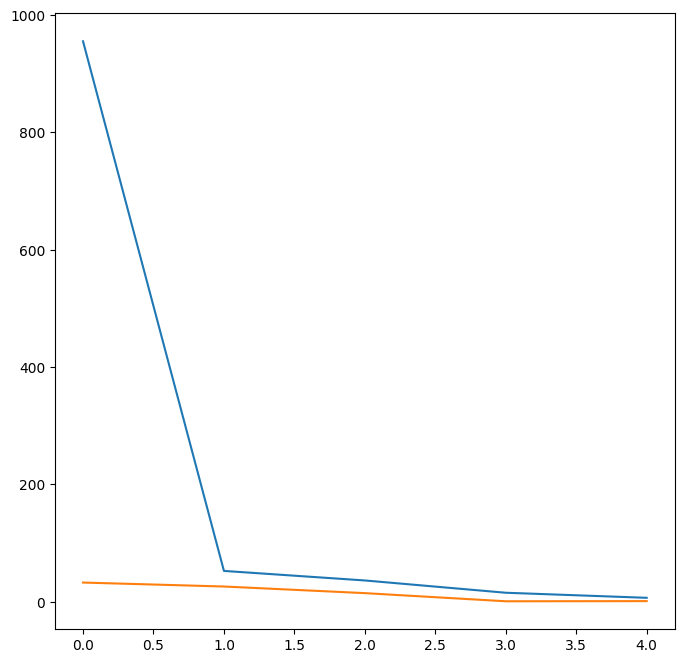

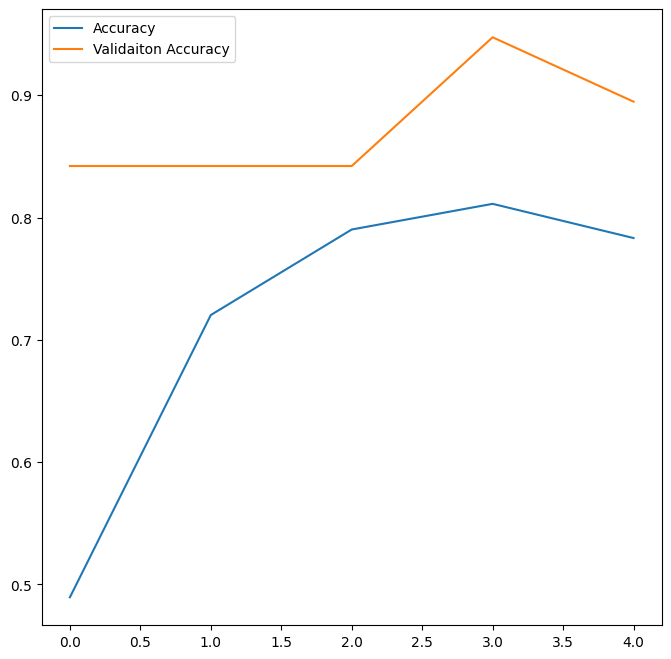

In [ ]:
plot_loss_acc_curves(history_1)

Model works great as first,
lets consider 10 classes instead of 2 and see how it works.

# Model 2
## 10 classes, same basic architecture
Model 1 works great rigth of the bat with a validation accuracy close to 90%. Lets see how the same model behaves with a categorical problem of 10 classes.

In [ ]:
decimal_data_dir = "/content"
decimal_classes = os.listdir(decimal_data_dir + "/train")[:10]
decimal_dest_dir = "/content/decinary"

decimal_train_ds,decimal_test_ds = get_train_test_ds(decimal_data_dir,decimal_dest_dir,decimal_classes,"categorical")

pineapple
cabbage
raddish
File already exists at:  /content/decinary/train/raddish
File already exists at:  /content/decinary/test/raddish
cauliflower
corn
File already exists at:  /content/decinary/train/corn
File already exists at:  /content/decinary/test/corn
tomato
File already exists at:  /content/decinary/train/tomato
File already exists at:  /content/decinary/test/tomato
garlic
sweetpotato
watermelon
File already exists at:  /content/decinary/train/watermelon
File already exists at:  /content/decinary/test/watermelon
pear
Found 1344 files belonging to 16 classes.
Found 159 files belonging to 16 classes.


In [ ]:
# Create same model
categorical_model_2 = create_basic_model("softmax",10)
categorical_model_2.compile(loss="categorical_crossentropy",
                             optimizer=Adam(),
                             metrics=["accuracy"]
                             )
history_2= categorical_model_2.fit(decimal_train_ds,
                        epochs=5,
                        steps_per_epoch=len(decimal_train_ds),
                        validation_data=decimal_test_ds,
                        validation_steps=int(0.25 * len(decimal_test_ds)))

Epoch 1/5
26/26 [==============================] - 262s 10s/step - loss: 368.6011 - accuracy: 0.0995 - val_loss: 2.1881 - val_accuracy: 0.3438
Epoch 2/5


In [ ]:
evaluation = categorical_model_2.evaluate(decimal_test_ds)
plot_loss_acc_curves(history_2)

# Model 3
## Duplicate of Model 2 trained for 10 epochs instead


In [ ]:
model_3 = create_basic_model("softmax",10)

model_3.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_3= model_3.fit(decimal_train_ds,
                        epochs=10,
                        steps_per_epoch=len(decimal_train_ds),
                        validation_data=decimal_test_ds,
                        validation_steps=int(0.25 * len(decimal_test_ds)))

In [ ]:
plot_loss_acc_curves(history_2)
plot_loss_acc_curves(history_3)

# Model 4
## Basic architecture for 20 classes
This is still fairly well, lets now attempts classifying along 20 various fruits.

In [ ]:
twenty_data_dir = "/content"
twenty_classes = os.listdir(twenty_data_dir + "/train")[:20]
twenty_dest_dir = "/content/twenty"


twenty_train_ds,twenty_test_ds = get_train_test_ds(twenty_data_dir,twenty_dest_dir,twenty_classes,"categorical")

pineapple
cabbage
raddish
cauliflower
corn
tomato
garlic
sweetpotato
watermelon
pear
peas
carrot
spinach
turnip
lettuce
eggplant
sweetcorn
capsicum
onion
grapes
Found 1796 files belonging to 20 classes.
Found 200 files belonging to 20 classes.


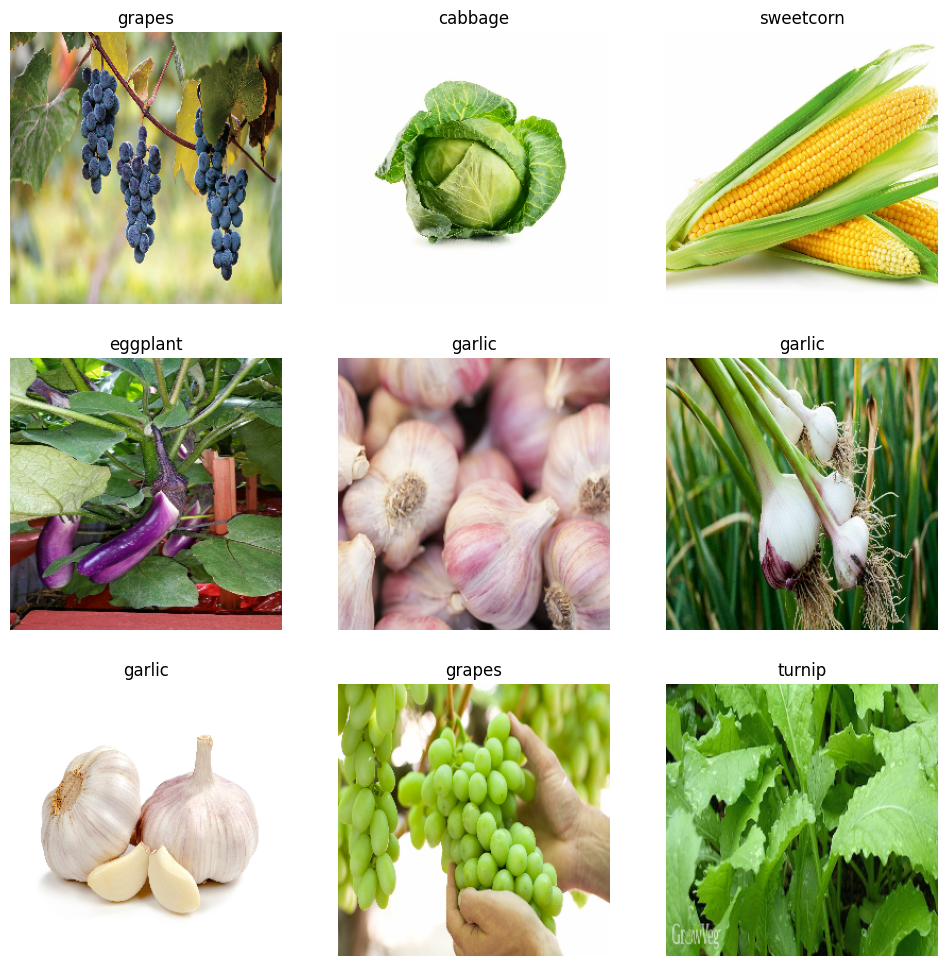

In [ ]:
view_random_images(twenty_train_ds,twenty_classes)

In [ ]:

model_4 = create_basic_model("softmax",20)

model_4.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_4 = model_4.fit(twenty_train_ds,
            epochs=5,
            steps_per_epoch=len(twenty_train_ds),
            validation_data=twenty_test_ds,
            validation_steps=int(0.25 * len(twenty_test_ds)))

Epoch 1/5
 1/57 [..............................] - ETA: 19:06 - loss: 34.4547 - accuracy: 0.0000e+00

In [ ]:
evaluation = model_4.evaluate(twenty_test_ds)
model_4_pred_probs = model_4.predict(twenty_test_ds)
model_4.summary()

# Model 5: Sample VGG-16
A model resembling the VGG-16 architecture found on:

 https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918

In [ ]:
model_5 = Sequential([
    Input(shape=INPUT_SHAPE),
    Rescaling(scale=1./255,offset=0), # Layer for normalizaton of data before entry.
    Conv2D(64,kernel_size=(3,3),activation="relu",padding="same"),
    Conv2D(64,kernel_size=(3,3),activation="relu",padding="same"),
    MaxPooling2D(),
    Conv2D(128,kernel_size=(3,3),activation="relu",padding="same"),
    Conv2D(128,kernel_size=(3,3),activation="relu",padding="same"),
    MaxPooling2D(name="maxpool"),
    Conv2D(256,kernel_size=(3,3),activation="relu",padding="same"),
    Conv2D(256,kernel_size=(3,3),activation="relu",padding="same"),
    Conv2D(256,kernel_size=(1,1),activation="relu",padding="same"),
    MaxPooling2D(),
    Flatten(),
    Dense(64,activation="relu"),
    Dense(20,activation="softmax")
])


model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_5 = model_5.fit(twenty_train_ds,
            epochs=10,
            steps_per_epoch=len(twenty_train_ds),
            validation_data=twenty_test_ds,
            validation_steps=int(0.25 * len(twenty_test_ds)))


Epoch 1/10
54/54 [==============================] - 84s 1s/step - loss: 3.1229 - accuracy: 0.0435 - val_loss: 2.9995 - val_accuracy: 0.0000e+00
Epoch 2/10
54/54 [==============================] - 53s 872ms/step - loss: 2.9950 - accuracy: 0.0528 - val_loss: 2.9968 - val_accuracy: 0.1250
Epoch 3/10
54/54 [==============================] - 54s 881ms/step - loss: 2.9944 - accuracy: 0.0580 - val_loss: 2.9996 - val_accuracy: 0.0000e+00
Epoch 4/10
54/54 [==============================] - 49s 799ms/step - loss: 2.9939 - accuracy: 0.0580 - val_loss: 2.9910 - val_accuracy: 0.0625
Epoch 5/10
54/54 [==============================] - 52s 832ms/step - loss: 2.9934 - accuracy: 0.0580 - val_loss: 2.9929 - val_accuracy: 0.0938
Epoch 6/10
54/54 [==============================] - 54s 888ms/step - loss: 2.9930 - accuracy: 0.0580 - val_loss: 2.9971 - val_accuracy: 0.0312
Epoch 7/10
54/54 [==============================] - 50s 819ms/step - loss: 2.9927 - accuracy: 0.0580 - val_loss: 2.9935 - val_accuracy: 0

In [ ]:
model_5_accuracy = model_5.evaluate(twenty_test_ds)[1]
model_5_accuracy

7/7 [==============================] - 8s 378ms/step - loss: 2.9970 - accuracy: 0.0503


0.05025125667452812

# Model 6:
## Transfer learning with ResNet101 architecture.


In [ ]:
ResNet101_layer = tf.keras.applications.ResNet101(include_top=False,classes=20)
print(f"imported Resnet101 model has {len(ResNet101_layer.layers)} layers.")

171446536/171446536 [==============================] - 1s 0us/step
imported Resnet101 model has 345 layers.


In [ ]:

Resnet_model = tf.keras.applications.ResNet101(include_top=False,input_shape=INPUT_SHAPE)

for layer in Resnet_model.layers:
  layer.trainable=False

x = Flatten()(Resnet_model.output)
x = Dense(1000,activation="relu")(x)
output = Dense(20,activation="softmax")(x)

model_6 = tf.keras.Model(Resnet_model.input,output,name="ResNet101")

model_6.compile(loss="categorical_crossentropy",
                metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam())





In [ ]:
history_6 = model_6.fit(twenty_train_ds,
                        epochs=5,
                        steps_per_epoch=len(twenty_train_ds),
                        validation_data=twenty_test_ds,
                        validation_steps=len(twenty_test_ds))

Epoch 1/5
54/54 [==============================] - 57s 824ms/step - loss: 34.6152 - accuracy: 0.5995 - val_loss: 1.0035 - val_accuracy: 0.9397
Epoch 2/5
54/54 [==============================] - 48s 779ms/step - loss: 0.5670 - accuracy: 0.9588 - val_loss: 1.0339 - val_accuracy: 0.9598
Epoch 3/5
54/54 [==============================] - 49s 782ms/step - loss: 0.1365 - accuracy: 0.9820 - val_loss: 1.2925 - val_accuracy: 0.9548


In [ ]:
predict_labels(model_6,twenty_test_ds,3)

# Model 7:
## Fitting the same Resnetmodel on all 36 image classes.

In [ ]:
all_data_dir = "/content"
all_classes = os.listdir(all_data_dir + "/train")
all_test_dir = "/content/all"

all_train_ds,all_test_ds = get_train_test_ds(all_data_dir,all_test_dir,all_classes,"categorical")

pineapple
File already exists at:  /content/all/train/pineapple
File already exists at:  /content/all/test/pineapple
cabbage
File already exists at:  /content/all/train/cabbage
File already exists at:  /content/all/test/cabbage
raddish
File already exists at:  /content/all/train/raddish
File already exists at:  /content/all/test/raddish
cauliflower
File already exists at:  /content/all/train/cauliflower
File already exists at:  /content/all/test/cauliflower
corn
File already exists at:  /content/all/train/corn
File already exists at:  /content/all/test/corn
tomato
File already exists at:  /content/all/train/tomato
File already exists at:  /content/all/test/tomato
garlic
File already exists at:  /content/all/train/garlic
File already exists at:  /content/all/test/garlic
sweetpotato
File already exists at:  /content/all/train/sweetpotato
File already exists at:  /content/all/test/sweetpotato
watermelon
File already exists at:  /content/all/train/watermelon
File already exists at:  /conte

In [ ]:
from tensorflow.keras.applications import ResNet101


Resnet_model = ResNet101(include_top=False,input_shape=INPUT_SHAPE)

for layer in Resnet_model.layers:
  layer.trainable=False

x = Flatten()(Resnet_model.output)
x = Dense(1000,activation="relu")(x)
output = Dense(36,activation="softmax")(x)


model_7 = tf.keras.Model(Resnet_model.input,output,name="ResNet101")

model_7.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_7 = model_7.fit(all_train_ds,
                epochs=5,
                validation_data=all_test_ds,
                validation_steps=int(0.2 * len(all_test_ds)))



Epoch 1/5
12/98 [==>...........................] - ETA: 24:51 - loss: 85.4499 - accuracy: 0.1953

In [ ]:
plot_loss_acc_curves(history_7)

In [ ]:
predict_labels(model_7,all_test_ds,random.randint(0,5))